# Invasive Species Monitoring

## W207-3 Final Project

### Authors: Stanimir Vichev, James Nguyen, Melwin Poovakottu, Jonah Smith

### Date: 08/21/2017

### Introduction:

Our team took part in the Invasive Species competition in Kaggle, trying to develop, configure and fit the best machine learning algorithm for binary classification of images. We tried several algorithms, such as Linear Support Vector Machines (SVM), Logistic Regression (LR), single-layer neural networks (single-NN), and Convolutional Neural Networks (CNN), as well as a variety of data augmentation methods to generate more data. In this report we start by describing the competition, followed by exploring the data set and looking at the data augmentation techniques employed. We then describe the implementation and performance of our initial attempts to use simpler algorithms, such as Linear SVM and LR. This is followed by a discussion of our main approach of using a CNN, the theory behind it, how it was implemented, and the resulting performance. We finish by discussing our Kaggle submission results and future improvements

### Competition:

Tangles of kudzu overwhelm trees in Georgia while cane toads threaten habitats in over a dozen countries worldwide. These are just two invasive species of many which can have damaging effects on the environment, the economy, and even human health. Despite widespread impact, efforts to track the location and spread of invasive species are so costly that they’re difficult to undertake at scale.

Currently, ecosystem and plant distribution monitoring depends on expert knowledge. Trained scientists visit designated areas and take note of the species inhabiting them. Using such a highly qualified workforce is expensive, time inefficient, and insufficient since humans cannot cover large areas when sampling.
Because scientists cannot sample a large quantity of areas, some machine learning algorithms are used in order to predict the presence or absence of invasive species in areas that have not been sampled. The accuracy of this approach is far from optimal, but still contributes to approaches to solving ecological problems.

In this playground competition, Kagglers are challenged to develop algorithms to more accurately identify whether images of forests and foliage contain invasive hydrangea or not. Techniques from computer vision alongside other current technologies like aerial imaging can make invasive species monitoring cheaper, faster, and more reliable.

The data set contains pictures taken in a Brazilian national forest. In some of the pictures there is Hydrangea, a beautiful invasive species original of Asia. Based on the training pictures and the labels provided, the participant should predict the presence of the invasive species in the testing set of pictures.

More details at: https://www.kaggle.com/c/invasive-species-monitoring

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from imgaug import augmenters as iaa
import imgaug as ia
import matplotlib.pyplot as plt
from tensorflow.python.framework import random_seed

import numpy as np
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Exploring the Data

We had around 2k images for training and 1k images for testing, the latter being unlabelled data used for our Kaggle submissions. Each image had colour and dimensions (866,1154,3), meaning that we were faced with the Curse of Dimensionality: having a lot of features and not enough data to cover the sample space. Additionally, the images were large and would take up a lot of memory, so we loaded them in batches for processing and training. The below classes and functions are used to perform data loading. 

In [10]:
#TODO change to train_data/train_labels.csv
data_path = "train_data/"
# data_path = "D:/MIDS/W207_3 Machine Learning/project_data/"
train_labels = pd.read_csv(data_path +"train_labels.csv")['invasive'].values

In [11]:
train_data_path = data_path
test_data_path = data_path +"test/"
# train_data_path = data_path + "train/"
# test_data_path = data_path + "test/"
def load_images(indices):
    images= np.zeros(shape=(len(indices), 866, 1154, 3), dtype=np.uint8)
    for p, i in enumerate(indices):
        im = Image.open(train_data_path+str(i+1)+".jpg")
    # open image file and store in variable `im`, then
        images[p] = np.array(im)
    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)

    return images

def load_test_images(indices):
    images= np.zeros(shape=(len(indices), 866, 1154, 3), dtype=np.uint8)
    for p, i in enumerate(indices):
        im = Image.open(test_data_path+str(i+1)+".jpg")
    # open image file and store in variable `im`, then
        newimg= np.array(im).reshape(866,1154,3)
    
        images[p] = newimg
    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)

    return images

def load_images_flat(indices, labels, path = data_path, seq = None):
    # resize to (400,300 from now and flatten array)
    # images= np.zeros(shape=(len(indices), 1440000), dtype=np.uint8)
    images= np.zeros(shape=(len(indices), 2998092), dtype=np.uint8)
    new_labels = np.zeros(shape = (labels.shape[0],))
    if seq:
        images= np.zeros(shape=(len(indices)*2, 2998092), dtype=np.uint8)
        new_labels = np.zeros(shape = (labels.shape[0]*2,))
    index = 0
    for p, i in enumerate(indices):
        im = Image.open(path+str(i+1)+".jpg")
        # doing an extra resize
        # arr = np.array(im.resize((800,600))).reshape(1,1440000)
        vanilla_arr = np.array(im).reshape(1,2998092)
        images[index] = vanilla_arr
        new_labels[index]=labels[p]
        if seq:
            aug_arr = seq.augment_images([np.array(im)])[0].reshape(1,2998092)
            index +=1
            images[index] = aug_arr
            new_labels[index]=labels[p]
        index +=1
    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)
    return images, new_labels

In [4]:
im_i = 3
print("Example Image, classified as "+str(train_labels[im_i-1]))
im = Image.open(train_data_path+str(im_i)+".jpg")
im.thumbnail([300,400])
im.save("example_invasive.png")
# im.show()

im_i = 1
print("Example Image, classified as "+str(train_labels[im_i-1]))
im = Image.open(train_data_path+str(im_i)+".jpg")
im.thumbnail([300,400])
im.save("example_no_invasive.png")
# im.show()

Example Image, classified as 1
Example Image, classified as 0


Example of an image with the invasive species:
![example_invasive](example_invasive.png)

Example of an image without the invasive species:
![example_no_invasive](example_no_invasive.png)

This class is created to load the images and to manage lazy loading of images in different epoches. Lazy loading is important because of limited GPU/CPU memory resources. The loading also shuffles images for every new epoch to maximize training efficiency. This version of the class is without image data augmentation.

In [6]:
class DataSet(object):

  def __init__(self,
               image_indices,
               labels,
               seed=None):
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    np.random.seed(seed1 if seed is None else seed2)
    self._num_examples = len(image_indices)
    self._image_indices = image_indices
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def image_indices(self):
    return self._image_indices

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def load_images(indices):

        images= np.zeros(shape=(len(indices), 866, 1154, 3), dtype=np.uint8)
        for i in indices:
            im = Image.open("train_data/"+str(i+1)+".jpg")
        # open image file and store in variable `im`, then
            images[i] = np.array(im)
        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)

        return images

  def next_batch(self, batch_size, shuffle=True):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    # Shuffle for the first epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = np.arange(self._num_examples)
      np.random.shuffle(perm0)
      self._image_indices = self.image_indices[perm0]
      self._labels = self.labels[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._image_indices[start:self._num_examples]
      labels_rest_part = self._image_indices[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._image_indices = self.image_indices[perm]
        self._labels = self.labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._image_indices[start:end]
      labels_new_part = self._labels[start:end]
      return load_images(np.concatenate((images_rest_part, images_new_part), axis =0)), np.concatenate((labels_rest_part, labels_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return load_images(self._image_indices[start:end]), self._labels[start:end]
  def next_pred_batch(self, batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    if start + batch_size > self._num_examples:
      rest_num_examples = self._num_examples - start
      images_rest_part = self._image_indices[start:self._num_examples]
      return load_test_images(images_rest_part)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return load_test_images(self._image_indices[start:end])

This class is created to load the images and to manage lazy loading of images in different epoches. Lazy loading is important because of limited GPU/CPU memory resources. The loading also shuffles images for every new epoch to maximize training efficiency. We also include data augmentation procedure to generate more images by apply techques such as blurring or rotation. The augmented data is combined with original data to produce new datasets. 

In [7]:
class DataAugSet(object):

  def __init__(self,
               image_indices,
               labels,
               seed=None):
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    np.random.seed(seed1 if seed is None else seed2)
    self._num_examples = len(image_indices)
    self._image_indices = image_indices
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def image_indices(self):
    return self._image_indices

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def load_images(self, indices):
        images= np.zeros(shape=(len(indices), 866, 1154, 3), dtype=np.uint8)
        for p, i in enumerate(indices):
            im = Image.open("train_data/"+str(i+1)+".jpg")
        # open image file and store in variable `im`, then
            images[p] = np.array(im)
        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)
#         sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        seq = iaa.Sequential([
#             iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
#             iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.GaussianBlur(sigma=(1, 4.0)), # blur images with a sigma of 0 to 3.0
#             sometimes(iaa.Affine( rotate=(-90, 90)))

        ])

    
        images_trans = seq.augment_images(images)
        return np.concatenate((images, images_trans), axis =0)
        return images
  def load_ori_images(self, indices):
        images= np.zeros(shape=(len(indices), 866, 1154, 3), dtype=np.uint8)
        for p, i in enumerate(indices):
            im = Image.open("train_data/"+str(i+1)+".jpg")
        # open image file and store in variable `im`, then
            images[p] = np.array(im)
        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)
        return images
  def load_test_images(self, indices):
    images= np.zeros(shape=(len(indices), 866, 1154, 3), dtype=np.uint8)
    for p, i in enumerate(indices):
        im = Image.open("test_data/test/"+str(i+1)+".jpg")
    # open image file and store in variable `im`, then
        newimg= np.array(im).reshape(866,1154,3)

        images[p] = newimg
    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)    
    return images
  def next_batch(self, batch_size, shuffle=True):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    # Shuffle for the first epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = np.arange(self._num_examples)
      np.random.shuffle(perm0)
      self._image_indices = self.image_indices[perm0]
      self._labels = self.labels[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
#       print("Finish epoch")

      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._image_indices[start:self._num_examples]
      labels_rest_part = self._image_indices[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._image_indices = self.image_indices[perm]
        self._labels = self.labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._image_indices[start:end]
      labels_new_part = self._labels[start:end]
      labels = np.concatenate((labels_rest_part, labels_new_part), axis=0)
      labels = np.concatenate((labels, labels), axis=0)
      return self.load_images(np.concatenate((images_rest_part, images_new_part), axis =0)),labels
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      labels = self._labels[start:end]
      labels = np.concatenate((labels, labels), axis=0)
      return self.load_images(self._image_indices[start:end]), labels
  def next_pred_batch(self, batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    if start + batch_size > self._num_examples:
      rest_num_examples = self._num_examples - start
      images_rest_part = self._image_indices[start:self._num_examples]
      return self.load_test_images(images_rest_part)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self.load_test_images(self._image_indices[start:end])
#   def next_val_batch(self, batch_size, shuffle=True):
#     """Return the next `batch_size` examples from this data set."""
#     start = self._index_in_epoch
#     # Shuffle for the first epoch
#     if self._epochs_completed == 0 and start == 0 and shuffle:
#       perm0 = np.arange(self._num_examples)
#       np.random.shuffle(perm0)
#       self._image_indices = self.image_indices[perm0]
#       self._labels = self.labels[perm0]
#     # Go to the next epoch
#     if start + batch_size > self._num_examples:
#       # Finished epoch
#       print("Finish epoch")
#       self._epochs_completed += 1
#       # Get the rest examples in this epoch
#       rest_num_examples = self._num_examples - start
#       images_rest_part = self._image_indices[start:self._num_examples]
#       labels_rest_part = self._image_indices[start:self._num_examples]
#       # Shuffle the data
#       if shuffle:
#         perm = np.arange(self._num_examples)
#         np.random.shuffle(perm)
#         self._image_indices = self.image_indices[perm]
#         self._labels = self.labels[perm]
#       # Start next epoch
#       start = 0
#       self._index_in_epoch = batch_size - rest_num_examples
#       end = self._index_in_epoch
#       images_new_part = self._image_indices[start:end]
#       labels_new_part = self._labels[start:end]
#       labels = np.concatenate((labels_rest_part, labels_new_part), axis=0)
#       return self.load_ori_images(np.concatenate((images_rest_part, images_new_part), axis =0)),labels
#     else:
#       self._index_in_epoch += batch_size
#       end = self._index_in_epoch
#       labels = self._labels[start:end]
#       return self.load_ori_images(self._image_indices[start:end]), labels
 


### Initial Attempts

We used Logistic Regression and Linear SVM in order to get a baseline accuracy on our train and test dataset. First, LR was chosen as it is the precursor to Neural Networks and CNNs, which we would use eventually. Linear SVMs, on the other hand, are another powerful algorithm for fitting non-linear data, especially one with a large number of features. 

#### Logistic Regression

we are using simple logistic regression in tensorflow to classify the images. We will convert each image to a one dimensional vector of length height X width X channels. We create two variables one for the feature weights another for the bias. We use cross entropy as the cost function and use gradient descent to find the minima.

First, we use the DataSet class to prepare the data for loading.

In [8]:
#Loading the Data
train_size = 1840
dev_size = 1840

y_train = train_labels[:train_size]
y_dev = train_labels[train_size:dev_size]
train_data = DataSet(np.arange(0,train_size), y_train)
test_data = DataSet(np.arange(train_size,len(train_labels)), y_dev)

y_validation = train_labels[train_size:]
validation_data = DataSet(np.arange(train_size,len(train_labels)), y_validation)
y_train[1]

y_train = train_labels[:1600]
y_dev = train_labels[1600:]
train_data = DataSet(np.arange(0,1600), y_train)
test_data = DataSet(np.arange(1600,len(train_labels)), y_dev)

X_val, y_val = validation_data.next_batch(80)
#reshaping data, so that all pixel values for an image are on a single line
X_val = X_val.reshape(X_val.shape[0],866*1154*3)

We then set up our Tensorflow graph and inputs.

In [15]:
height = 866
width = 1154
channels = 3
n_inputs = height * width

n_outputs = 2
# reset tf graph before run
reset_graph()

# set up the input tf tensors
with tf.name_scope("inputs"):
    X_lgr = tf.placeholder(tf.float32, shape=[None, height* width* channels], name="X_lgr")

    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')
    W = tf.Variable(tf.zeros([height* width* channels,2]))
    b = tf.Variable(tf.zeros([2]))
    
with tf.name_scope("Logistic_regression"):
    #y_lgr =tf.transpose(tf.matmul(X_lgr,W) + b)
    #y_lgr.eval()
    y_lgr =tf.matmul(X_lgr,W) + b
    #print(y_lgr.shape)
    
with tf.name_scope("train_lgr"):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_lgr, labels=y)
    loss_lgr = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.GradientDescentOptimizer(0.5)
    training_lgr = optimizer.minimize(loss_lgr)

with tf.name_scope("eval_logistiic"):
    correct_lgr = tf.nn.in_top_k(y_lgr, y, 1)
    accuracy_lgr = tf.reduce_mean(tf.cast(correct_lgr, tf.float32))        

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

The below classes are used to capture our model parameters when we manage to fit a new model. This is needed so that we could reload them later and run our predictions with them.

In [16]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

With the tf tensors set, we can go on to fit our model. We will keep running until we stop making any progress on our loss function or when we reach 20 iterations. The train and test accuracy at each step are printed.  

In [18]:
n_epochs = 20
batch_size = 80

best_loss_val = np.infty
check_interval = 5
checks_since_last_progress = 0
max_checks_without_progress = 10
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(train_data.num_examples // batch_size):
            X_batch, y_batch = train_data.next_batch(batch_size)
            X_batch = X_batch.reshape(X_batch.shape[0],height* width* channels)
            sess.run(training_lgr, feed_dict={X_lgr: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss_lgr.eval(feed_dict={X_lgr: X_val, y: y_val})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
            #print( best_loss_val," ",loss_val)
        acc_train = accuracy_lgr.eval(feed_dict={X_lgr: X_batch, y: y_batch})
        acc_val = accuracy_lgr.eval(feed_dict={X_lgr: X_val,
                                           y: y_val})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    save_path = saver.save(sess, "./my_lr_model")

Epoch 0, train accuracy: 36.2500%, valid. accuracy: 38.7500%, valid. best loss: 35662.085938
Epoch 1, train accuracy: 37.5000%, valid. accuracy: 42.5000%, valid. best loss: 8927.712891
Epoch 2, train accuracy: 47.5000%, valid. accuracy: 45.0000%, valid. best loss: 8927.712891
Epoch 3, train accuracy: 73.7500%, valid. accuracy: 68.7500%, valid. best loss: 8927.712891
Epoch 4, train accuracy: 53.7500%, valid. accuracy: 46.2500%, valid. best loss: 8927.712891
Early stopping!


Please see below for a sample output:

Epoch 0, train accuracy: 76.2500%, valid. accuracy: 63.7500%, valid. best loss: 24724.953125

Epoch 1, train accuracy: 72.5000%, valid. accuracy: 70.0000%, valid. best loss: 10541.773438

Epoch 2, train accuracy: 47.5000%, valid. accuracy: 47.5000%, valid. best loss: 10541.773438

Epoch 3, train accuracy: 67.5000%, valid. accuracy: 62.5000%, valid. best loss: 10541.773438

Epoch 4, train accuracy: 68.7500%, valid. accuracy: 65.0000%, valid. best loss: 10233.330078

Epoch 5, train accuracy: 78.7500%, valid. accuracy: 70.0000%, valid. best loss: 10233.330078

Epoch 6, train accuracy: 76.2500%, valid. accuracy: 62.5000%, valid. best loss: 10233.330078

Epoch 7, train accuracy: 61.2500%, valid. accuracy: 61.2500%, valid. best loss: 10233.330078

Epoch 8, train accuracy: 68.7500%, valid. accuracy: 63.7500%, valid. best loss: 10233.330078

Epoch 9, train accuracy: 62.5000%, valid. accuracy: 61.2500%, valid. best loss: 10233.330078

Epoch 10, train accuracy: 57.5000%, valid. accuracy: 62.5000%, valid. best loss: 10233.330078

Epoch 11, train accuracy: 67.5000%, valid. accuracy: 66.2500%, valid. best loss: 10233.330078

Epoch 12, train accuracy: 56.2500%, valid. accuracy: 63.7500%, valid. best loss: 10233.330078

Epoch 13, train accuracy: 61.2500%, valid. accuracy: 62.5000%, valid. best loss: 10233.330078

Epoch 14, train accuracy: 65.0000%, valid. accuracy: 65.0000%, valid. best loss: 10233.330078

Epoch 15, train accuracy: 80.0000%, valid. accuracy: 70.0000%, valid. best loss: 10233.330078

Epoch 16, train accuracy: 52.5000%, valid. accuracy: 56.2500%, valid. best loss: 10233.330078

Epoch 17, train accuracy: 81.2500%, valid. accuracy: 71.2500%, valid. best loss: 10233.330078

Early stopping!

We can see from our results that LR has strongly fluctuating training and testing accuracy, with the highest training accuracy being 81% and the highest test accuracy being 71%. This means that the algorithm is not complex enough and seems to be underfitting the data set, which could be down to the fact that LR represents only a single neuron in an NN, so it isn't complex enough to represent any nonlinear relationships correctly. 

#### Single-layer NN

We decided to expand on our LR implementation by adding a hidden layer and creating a simple neural network, which should be much more capable of capturing non-linearity in the image data. 

First, we set up the data:

In [ ]:
y_train = train_labels[:1800]
y_dev = train_labels[1800:]
train_data = DataSet(np.arange(0,1800), y_train)
test_data = DataSet(np.arange(1800,len(train_labels)), y_dev)

y_validation = train_labels[1800:]
validation_data = DataSet(np.arange(1800,len(train_labels)), y_validation)

Then we prepare the tensorflow variables and graph. For this attempt, we add a single fully connected NN layer between the input and output layers:

In [ ]:
height = 866
width = 1154
channels = 3
n_inputs = height * width

n_fc1 = 32
fc1_dropout_rate = 0.5

n_outputs = 2

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    X_resized = tf.image.resize_images(X, [400, 300])
    X_resized_flat = tf.reshape(X_resized,shape=[-1,400* 300*channels])

    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')
    
    X_nn = tf.placeholder(tf.float32, shape=[None, 400* 300* channels], name="X_nn")

with tf.name_scope("fc1_nn"):
    fc1_nn = tf.layers.dense(X_resized_flat, 800, activation=tf.nn.relu, name="fc1_nn")
    #where do you use drop out layer
    fc1_drop = tf.layers.dropout(fc1_nn, fc1_dropout_rate, training=training)

with tf.name_scope("output_nn"):
    logits_nn = tf.layers.dense(fc1_nn, n_outputs, name="output_nn")
    Y_proba = tf.nn.softmax(logits_nn, name="Y_proba")
    
with tf.name_scope("train_nn"):
    xentropy_nn = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_nn, labels=y)
    loss_nn = tf.reduce_mean(xentropy_nn)
    optimizer_nn = tf.train.AdamOptimizer()
    training_op_nn = optimizer_nn.minimize(loss_nn)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits_nn, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))   
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

We then fit the NN and monitor performance:

In [ ]:
X_val, y_val = validation_data.next_batch(80)
n_epochs = 10
batch_size = 30

best_loss_val = np.infty
check_interval = 5
checks_since_last_progress = 0
max_checks_without_progress = 30
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(train_data.num_examples // batch_size):
            X_batch, y_batch = train_data.next_batch(batch_size)
            #X_batch =X_batch.reshape(height*width*channels)
            sess.run(training_op_nn, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss_nn.eval(feed_dict={X: X_val, y: y_val})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val,y: y_val})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    save_path = saver.save(sess, "./my_isd_model")

Sample output from our runs:

Epoch 0, train accuracy: 73.3333%, valid. accuracy: 71.2500%, valid. best loss: 10.095164

Epoch 1, train accuracy: 70.0000%, valid. accuracy: 76.2500%, valid. best loss: 8.895315

Epoch 2, train accuracy: 80.0000%, valid. accuracy: 73.7500%, valid. best loss: 5.483994

Epoch 3, train accuracy: 60.0000%, valid. accuracy: 73.7500%, valid. best loss: 4.458233

Epoch 4, train accuracy: 46.6667%, valid. accuracy: 62.5000%, valid. best loss: 3.471657

Epoch 5, train accuracy: 73.3333%, valid. accuracy: 60.0000%, valid. best loss: 2.967641

Epoch 6, train accuracy: 96.6667%, valid. accuracy: 72.5000%, valid. best loss: 2.967641

Epoch 7, train accuracy: 93.3333%, valid. accuracy: 75.0000%, valid. best loss: 2.715569

Epoch 8, train accuracy: 93.3333%, valid. accuracy: 77.5000%, valid. best loss: 2.494355

Epoch 9, train accuracy: 100.0000%, valid. accuracy: 73.7500%, valid. best loss: 2.358074

From the results, we see a marked improvement on the training accuracy, as the single-layer NN captures more of the complexity in the data. The test accuracy is also slightly better than before. 

#### Linear SVM

Next, we fit a model on our data using the Linear SVM algorithm. As we wanted to generate more results by applying data augmentation to the data as it was fed to the algorithm, we had to use a modified DataSet class for SVM.

In [19]:
class DataSetSVM(object):

    def __init__(self,
                image_indices,
                labels,
                dataPath = data_path,
                seed=None,
                aug_array = []):
        seed1, seed2 = random_seed.get_seed(seed)
        # If op level seed is not set, use whatever graph level seed is returned
        np.random.seed(seed1 if seed is None else seed2)
        self._num_examples = len(image_indices)
        self._image_indices = image_indices
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self.path = dataPath
        self.aug_array = aug_array

    @property
    def image_indices(self):
        return self._image_indices

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size, shuffle=True):
        """Return the next `batch_size` examples from this data set."""
        
        # pick augmentation sequence to apply.
        # applying an augmentation sequence means we will return twice the amount of batch_size items,
        # as each image sample will be read, and a copy of it will be augmented, making the samples 2*batch_size
        aug_seq = np.random.choice(self.aug_array, 1)[0] if self.aug_array else None
        
        start = self._index_in_epoch
        # Shuffle for the first epoch
        if self._epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self._num_examples)
            np.random.shuffle(perm0)
            self._image_indices = self.image_indices[perm0]
            self._labels = self.labels[perm0]
        # Go to the next epoch
        if start + batch_size > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            images_rest_part = self._image_indices[start:self._num_examples]
            labels_rest_part = self._image_indices[start:self._num_examples]
            # Shuffle the data
            if shuffle:
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._image_indices = self.image_indices[perm]
                self._labels = self.labels[perm]
          # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            images_new_part = self._image_indices[start:end]
            labels_new_part = self._labels[start:end]
            labels = np.concatenate((labels_rest_part, labels_new_part), axis=0)
            images, labels= load_images_flat(np.concatenate((images_rest_part, images_new_part), axis =0), labels, path = self.path, seq = aug_seq)
            return images, labels
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            labels = self._labels[start:end]
            images, labels = load_images_flat(self._image_indices[start:end], labels, path = self.path, seq = aug_seq)            
            return images, labels

##### Data Augmentation

As we load images for training, we want to make a copy of each image, apply a random set of augmentations to it and add it to our dataset. This is so that we can generate more images for training that are roughly based on the current dataset and have some reasonable differences. For SVM, we chose to add some amount of Gaussian Blur, flip the image left-right, or flip it up-down. In order to implement this, we used the imgaug library, which allows us to define sequences of augmentations to be applied to each image passed to the sequence. Then we can define a sequence for every combination of augmentations listed above, and select one randomly to apply to each image.  

In [5]:
# see https://github.com/aleju/imgaug
flip_lr_seq = iaa.Sequential([
    iaa.Fliplr(1), # horizontally flip
])

flip_ud_seq = iaa.Sequential([
    iaa.Flipud(1), # vertically flip
])

gauss_1_seq = iaa.Sequential([
    iaa.GaussianBlur(1.0), # blur images with a sigma of 0 to 3.0
])

flip_seq = iaa.Sequential([
    iaa.Flipud(1), # vertically flip
    iaa.Fliplr(1), # horizontally flip
])

flip_ud_gauss_seq = iaa.Sequential([
    iaa.Flipud(1), # vertically flip
    iaa.GaussianBlur(1.0),
])

flip_lr_gauss_seq = iaa.Sequential([
    iaa.Fliplr(1), # vertically flip
    iaa.GaussianBlur(1.0),
])

flip_2_gauss_seq = iaa.Sequential([
    iaa.Flipud(1), # vertically flip
    iaa.Fliplr(1), # horizontally flip
    iaa.GaussianBlur(1.0),
])
# pass this array to DataSet object. during next_batch() one of the seq in the array will be picked randomly and applied when loading data
seq_array = [flip_lr_seq, flip_ud_seq, gauss_1_seq, flip_seq, flip_ud_gauss_seq, flip_lr_gauss_seq, flip_2_gauss_seq]

Below you can see an example of how the imgaug library works, and how we use sequences.

In [12]:
print(np.random.choice(seq_array, 1))

img = Image.open(data_path + "train/"+str(3)+".jpg")
seq = iaa.Sequential([
#     iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Flipud(1), # horizontally flip image
    iaa.GaussianBlur(sigma=(1.0)) # blur images with a sigma of 1.0
])
# img.show()
img.thumbnail([500,600])
img.save("example_no_aug1.png")
arrg = np.array(img)
im_aug = seq.augment_images(arrg)
new_img = Image.fromarray(im_aug,'RGB')
img.thumbnail([500,600])
new_img.save("example_aug1.png")

[ Sequential(name=UnnamedSequential, augmenters=[Fliplr(name=UnnamedFliplr, parameters=[Binomial(Deterministic(float 1.00000000))], deterministic=False)], deterministic=False)]


Example of an image without aug:
![example_no_aug1](example_no_aug1.png)

Example of an image with aug:
![example_aug1](example_aug1.png)

We now prepare the data for loading:

In [38]:
# prepare labels
train_labels = pd.read_csv(data_path + "train_labels.csv")['invasive'].values
y_train = train_labels[:1800]
y_validation = train_labels[1800:]

# prepare data
train_data = DataSetSVM(np.arange(0,1800), y_train, dataPath = data_path + "train/", aug_array = seq_array)
validation_data = DataSetSVM(np.arange(1800,len(train_labels)), y_validation, dataPath = data_path + "train/")

We also set up the parameters we will need for implementing SVM in tensorflow:

In [39]:
svmC = 100
num_features = 2998092
n_epochs = 20
batch_size = 80
best_loss_val = np.infty
check_interval = 5
checks_since_last_progress = 0
max_checks_without_progress = 8
best_model_params = None 

Below we implement the Linear SVM in TensorFlow. We define our weights and bias, as well as the y function (y=W*x-b) we will use in the cost function. We then define the regularization and hinge loss functions in order to create the final loss function that we minimize using gradient descent. The regularization loss function penalizes us having to move misclassified examples across the margin, while the hinge function is used to determine the best margin possible. In the end we also add evaluation functions for accuracy calculation. 

In [40]:
# set graph
reset_graph()

# inputs
X = tf.placeholder(tf.float32, shape=[None, num_features], name="X")
y = tf.placeholder(tf.float32, shape=[None], name="y")
training = tf.placeholder_with_default(False, shape=[], name='training')

# set weights and create function
W = tf.Variable(tf.zeros([num_features,1]))
b = tf.Variable(tf.zeros([1]))
y_raw = tf.matmul(X,W) - b

# Optimization.
regularization_loss = tf.reduce_sum(tf.square(W))

# *2 needed as the training involves augmentation, which adds each image again in an augmented form, so we get twice as big an array from load_image_flat
hinge_loss = tf.reduce_mean(tf.maximum(tf.zeros([batch_size*2,1]), 1 - y*y_raw))

svm_loss = svmC*regularization_loss + hinge_loss
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(svm_loss)

# SVM Loss for validation set;
# This is needed because the training involves augmentation, which adds each image again in an augmented form
# This doesn't happen for validation
hinge_loss_test = tf.reduce_mean(tf.maximum(tf.zeros([batch_size,1]), 1 - y*y_raw))
svm_loss_test = svmC*regularization_loss + hinge_loss_test

# Evaluation.
predicted_class = tf.sign(y_raw);
correct_prediction = tf.equal(y,predicted_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

We now run our SVM algorithm:

In [ ]:
X_val, y_val = validation_data.next_batch(80)
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        # start an epoch
        for iteration in range(train_data.num_examples // batch_size):
            # get a batch to run
            X_batch, y_batch = train_data.next_batch(batch_size)
            # run the train
            print(X_batch.shape)
            print(X_val.shape)
            sess.run(train_step, feed_dict={X: X_batch, y: y_batch, training: True})
            loss_val = svm_loss_test.eval(feed_dict={X: X_val,y: y_val})
            if loss_val < best_loss_val:
                best_loss_val = loss_val
                checks_since_last_progress = 0
            else:
                checks_since_last_progress += 1
        # check accuracy
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            print()
            break

Sample output:

Epoch 0, train accuracy: 66.2500%, valid. accuracy: 65.0000%, valid. best loss: 0.366802

Epoch 1, train accuracy: 61.2500%, valid. accuracy: 65.0000%, valid. best loss: 0.366787

Epoch 2, train accuracy: 56.2500%, valid. accuracy: 65.0000%, valid. best loss: 0.366772

Epoch 3, train accuracy: 53.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366757

Epoch 4, train accuracy: 55.0000%, valid. accuracy: 65.0000%, valid. best loss: 0.366743

Epoch 5, train accuracy: 68.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366728

Epoch 6, train accuracy: 68.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366713

Epoch 7, train accuracy: 67.5000%, valid. accuracy: 65.0000%, valid. best loss: 0.366699

Epoch 8, train accuracy: 73.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366684

Epoch 9, train accuracy: 66.2500%, valid. accuracy: 65.0000%, valid. best loss: 0.366669

Epoch 10, train accuracy: 63.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366654

Epoch 11, train accuracy: 62.5000%, valid. accuracy: 65.0000%, valid. best loss: 0.366640

Epoch 12, train accuracy: 65.0000%, valid. accuracy: 65.0000%, valid. best loss: 0.366625

Epoch 13, train accuracy: 57.5000%, valid. accuracy: 65.0000%, valid. best loss: 0.366611

Epoch 14, train accuracy: 68.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366596

Epoch 15, train accuracy: 65.0000%, valid. accuracy: 65.0000%, valid. best loss: 0.366581

Epoch 16, train accuracy: 73.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366567

Epoch 17, train accuracy: 66.2500%, valid. accuracy: 65.0000%, valid. best loss: 0.366552

Epoch 18, train accuracy: 53.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366538

Epoch 19, train accuracy: 57.5000%, valid. accuracy: 65.0000%, valid. best loss: 0.366523

Epoch 20, train accuracy: 60.0000%, valid. accuracy: 65.0000%, valid. best loss: 0.366509

Epoch 21, train accuracy: 58.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366494

Epoch 22, train accuracy: 60.0000%, valid. accuracy: 65.0000%, valid. best loss: 0.366479

Epoch 23, train accuracy: 62.5000%, valid. accuracy: 65.0000%, valid. best loss: 0.366465

Epoch 24, train accuracy: 65.0000%, valid. accuracy: 65.0000%, valid. best loss: 0.366450

Epoch 25, train accuracy: 62.5000%, valid. accuracy: 65.0000%, valid. best loss: 0.366436

Epoch 26, train accuracy: 63.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366422

Epoch 27, train accuracy: 61.2500%, valid. accuracy: 65.0000%, valid. best loss: 0.366407

Epoch 28, train accuracy: 75.0000%, valid. accuracy: 65.0000%, valid. best loss: 0.366393

Epoch 29, train accuracy: 53.7500%, valid. accuracy: 65.0000%, valid. best loss: 0.366378

As we can see from the results, SVM has a very low, albeit consistent train and test accuracy. Even with additional data augmentation samples, it is unable to do better than 75% train and 65% test accuracy. This shows that SVM underfits the training data, even if we use very low regularization values (high C). As a whole, it looks like SVM cannot capture the complexities of the sample data well enough to fit it accurately. 

### Main Approach: CNN

Following the bad performance of our initial approaches, we decided to use Convolutional Neural Networks as the main engine for prediction. CNNs are neural networks that are specifically designed to work with image data. The convolutional layers use a specifically designed filter to reduce the dimensions of the images while maintaining the overall composition and variance of the data. A combination of convolutional, max pool, and fully connected layers allow us to build a neural network with a much better performance than our baseline models.

The structure of the network is as follows:
- Convolution layer 1
- Convolution layer 2
- Max pool layer
- Fully connected layer
- Output layer 

After our initial testing showed that we overfit the training data, we applied following techniques to improve model performance and avoid overfitting:
1. Applied 25% drop out at max pool layer and fully connected layer
2. We use data augmentation techniques such as Gaussian blur and image rotation to generate additional images variance 

We use tensorflow version 1.0 and trained the model using P2 GPU instance in AWS. This is because CNNs require a lot of processing power. Therefore, our opportunity to multiple tests and runs was limited by the high cost of running this on an expensive AWS server. 

It is also important to note that we had to resize the input images to (300,400,3) because otherwise we would run out of memory. 

Below we build the tensorflow graph for the models. We are testing several variants of the models to compare performance.

In [14]:
height = 866
width = 1154
channels = 3
n_inputs = height * width

conv1_fmaps = 64
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 32
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25


pool3_fmaps = conv2_fmaps

n_fc1 = 32
fc1_dropout_rate = 0.25

n_outputs = 2

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    X_resized = tf.image.resize_images(X, [300, 360])

    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')


conv1 = tf.layers.conv2d(X_resized, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 150 * 180])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1_drop, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [15]:
# Possibly remove this
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

First, we try to fit the data without using data augmentation:

In [27]:
y_test = train_labels[2240:]
test_data = DataSet(np.arange(2240,len(train_labels)), y_test)
train_data =  DataSet(np.arange(0,2240), train_labels[:2240])
X_val, y_val = test_data.next_batch(55)




n_epochs = 100
batch_size = 70

best_loss_val = np.infty
check_interval = 5
checks_since_last_progress = 0
max_checks_without_progress = 120
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(train_data.num_examples // batch_size):
            X_batch, y_batch = train_data.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_val,
                                                y: y_val})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_val, y: y_val})
        loss_val = loss.eval(feed_dict={X: X_val,
                                                y: y_val})
        print("Epoch {}, train accuracy: {:.4f}%, test accuracy: {:.4f}%, loss: {:.6f}, best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_test * 100, loss_val, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)

    save_path = saver.save(sess, "./my_isd_model22")

Epoch 0, train accuracy: 60.0000%, test accuracy: 58.1818%, loss: 0.665791, best loss: 0.665741
Epoch 1, train accuracy: 74.2857%, test accuracy: 72.7273%, loss: 0.599543, best loss: 0.601388
Epoch 2, train accuracy: 68.5714%, test accuracy: 67.2727%, loss: 0.606988, best loss: 0.578064
Epoch 3, train accuracy: 81.4286%, test accuracy: 76.3636%, loss: 0.566922, best loss: 0.524850
Epoch 4, train accuracy: 88.5714%, test accuracy: 85.4545%, loss: 0.434947, best loss: 0.434941
Epoch 5, train accuracy: 98.5714%, test accuracy: 80.0000%, loss: 0.439690, best loss: 0.413104
Epoch 6, train accuracy: 97.1429%, test accuracy: 72.7273%, loss: 0.781371, best loss: 0.413104
Epoch 7, train accuracy: 98.5714%, test accuracy: 74.5455%, loss: 0.544343, best loss: 0.413104
Epoch 8, train accuracy: 100.0000%, test accuracy: 72.7273%, loss: 0.884409, best loss: 0.413104
Epoch 9, train accuracy: 100.0000%, test accuracy: 72.7273%, loss: 0.588346, best loss: 0.413104
Epoch 10, train accuracy: 100.0000%, t

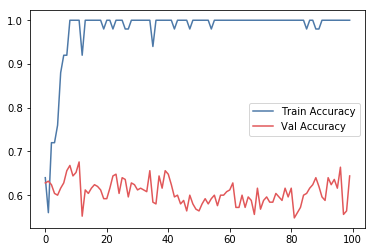

In [21]:

# plt.plot(range(len(best_losses)),best_aug_losses, label ='best losses')
# plt.plot(range(len(eporch_losses)),eporch_aug_losses, label ='eporch losses' )
plt.plot(range(len(accs_train)),accs_train, label ='Train Accuracy' )
plt.plot(range(len(accs_val)),accs_val,label ='Val Accuracy' )

plt.legend(loc='best')
plt.show()


The results show that CNN is much better at fitting the training data correctly when compared to Linear SVM or LR. However, the testing accuracy is around 70%, with the best test accuracy around 80%. This does show that we are doing much better than with the baseline models, but there could be some overfitting in this case.  

Below we are adding the augmented data in order to see if this will improve our results. 

In [ ]:
# train_aug_data =  DataAugSet(np.arange(0,2130), train_labels[:2130])
best_aug_losses =[]
eporch_aug_losses=[]
accs_aug_train =[]
accs_aug_val =[]
epoch_aug_stop=0

y_test = train_labels[2240:]
test_data = DataSet(np.arange(2240,len(train_labels)), y_test)
train_aug_data =  DataAugSet(np.arange(0,2240), train_labels[:2240])
X_val, y_val = test_data.next_batch(55)




n_epochs = 100
batch_size = 40

best_loss_val = np.infty
check_interval = 5
checks_since_last_progress = 0
max_checks_without_progress = 120
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(train_aug_data.num_examples // batch_size):

            
            X_batch, y_batch = train_aug_data.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_aug_val = loss.eval(feed_dict={X: X_val, y:y_val})
                if loss_aug_val < best_loss_val:
                    best_loss_val = loss_aug_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1


        acc_aug_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        
#         loss_aug_val = loss.eval(feed_dict={X: X_val, y:y_val})
        acc_aug_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        
        print("Epoch {}, train accuracy: {:.4f}%, test accuracy: {:.4f}%, best loss: {:.6f}".format(
                  epoch, acc_aug_train * 100, acc_aug_val * 100, best_loss_val))
#         accs_aug_train.append(acc_aug_train)
#         accs_aug_val.append(acc_aug_val)
#         best_aug_losses.append(best_loss_val)
#         eporch_aug_losses.append(loss_aug_val)

        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            epoch_stop = epoch
            break

    if best_model_params:
        restore_model_params(best_model_params)

    save_path = saver.save(sess, "./my_isd_model102")


Epoch 0, train accuracy: 70.0000%, test accuracy: 54.5455%, best loss: 0.605495


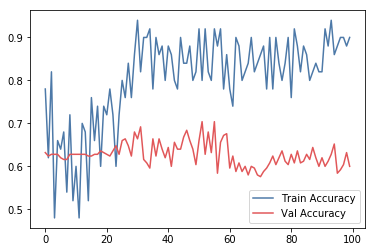

In [20]:

# plt.plot(range(len(best_losses)),best_losses, label ='best losses')
# plt.plot(range(len(eporch_losses)),eporch_losses, label ='eporch losses' )
plt.plot(range(len(accs_train)),accs_aug_train, label ='Train Accuracy' )
plt.plot(range(len(accs_val)),accs_aug_val,label ='Val Accuracy' )

plt.legend(loc='best')
plt.show()


As can be seen form the graph, our training accuracy decreased with the addition of augmented data and increased dropout rate. This means we managed to reduce some of the overfitting by adding more images which the model has to adjust for, as well as by increasing the number of coefficients randomly set to zero during training. However, we didn't see any consistent improvement on the test data accuracy, which shows that our model still needs to be further adjusted. 

The below code shows how we tried to evaluate our performance on the test dataset. We used the different CNN models we generated previously and for which we saved our parameters. We also generate the labels being assigned to the data at the time of the run. 

In [9]:
#Evaluation
test_data = DataSet(np.arange(2050,len(train_labels)), train_labels[2050:])
test_batch_size = 10
acc_test =[]
with tf.Session() as sess:
    saver.restore(sess,"./my_isd_model101")
    for iteration in range(test_data.num_examples // test_batch_size):
        X_test, y_test = test_data.next_batch(test_batch_size)
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y:y_test}))
        #print("probability", Y_proba.eval(feed_dict={X: X_test}))
        #print("actual", y_test)

       

print("Test accuracy with data aug:", sum(acc_test)/len(acc_test))


Test accuracy with data aug: 0.887499998013


In [31]:
#Evaluation
test_data = DataSet(np.arange(2240,len(train_labels)), train_labels[2240:])
test_batch_size = 5
acc_test =[]
with tf.Session() as sess:
    saver.restore(sess,"./my_isd_model2")
    for iteration in range(test_data.num_examples // test_batch_size):
        X_test, y_test = test_data.next_batch(test_batch_size)
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y:y_test}))
        #print("probability", Y_proba.eval(feed_dict={X: X_test}))
        #print("actual", y_test)

       

print("Test accuracy with data aug:", sum(acc_test)/len(acc_test))


Test accuracy with data aug: 0.836363646117


In [10]:
#Evaluation
test_data = DataSet(np.arange(2050,len(train_labels)), train_labels[2050:])
test_batch_size = 10
acc_test =[]
with tf.Session() as sess:
    saver.restore(sess,"./my_isd_model2")
    for iteration in range(test_data.num_examples // test_batch_size):
        X_test, y_test = test_data.next_batch(test_batch_size)
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y:y_test}))
        #print("probability", Y_proba.eval(feed_dict={X: X_test}))
        #print("actual", y_test)

       

print("Test accuracy:", sum(acc_test)/len(acc_test))


Test accuracy: 0.924999994536


In [10]:
#prediction for test set
pred_data = DataSet(np.arange(0,1531), None)
pred_batch_size = 50
prediction_labels =[]
with tf.Session() as sess:
    saver.restore(sess,"./my_isd_model101")
    for iteration in range(pred_data.num_examples // pred_batch_size+1):
        X_pred = pred_data.next_pred_batch(pred_batch_size)
        prediction_labels.append(Y_proba.eval(feed_dict={X: X_pred}))


#print("labels:", prediction_labels)


In [11]:
flat_list = [item for sublist in prediction_labels for item in sublist]
final_list=[]
for i in range(len(flat_list)):
    if(flat_list[i][0]>flat_list[i][1]):
        final_list.append([i+1,0])
    else: final_list.append([i+1,1])

np.savetxt("output_aug14_2.csv", final_list, delimiter=",")
        
        

### Kaggle Results

With our best CNN model configuration, which included data augmentation and a high dropout rate during training, we managed to reach 224th place in the Kaggle competition, with a submission score of 0.82862. This was an improvement on our previous submission of 0.75753, which didn't include these methods for regularization. This shows that we managed to reduce overfitting in a way that had an effect on our prediction accuracy on unseen data.  

### Future Development

If given more time and resources, we could improve our model and accuracy in a number of ways. First, if we could get the hardware required (with a lot of memory and high-peformance GPUs), we would be able to feed the complete images into our CNN, which should give it a lot more information to work with and hopefully improve its accuracy. Second, we could also test more layer setups for our CNN, possibly adding more convolutional layers and working with bigger intermediate dimensions. Third, we could generate even more augmented images and fit models using a bigger training set. Fourth, we could employ feature engineering for image data in order to improve the performance of our CNNs further. Fifth, we could work on developing non-linear SVM algorithms (not currently available in TensorFlow) and see if SVMs can be made to better process image data, since they require less hardware resources to perform.

### Conclusion

In this project we attempted to build a classifier that can work out whether a certain invasive species of plant (Hydrangea) is present in photos of wildlife areas in Brazil. We started by trying to use the Logistic Regression, single-layer NN, and Linear SVM algorithms, although they proved inadequate for the complexity of the input data. We then moved on to using CNNs that are better suited to working with image data, managing to achieve a much better performance. We tried to adjust for overfitting and improve our performance further by using data augmentation and a higher dropout rate to generate more samples and regularize. This improved our accuracy on unseen data, as noted by our Kaggle results before and after the change. Finally, we identified ways we could improve this projecct in the future, so we could one day hope to better understand the spread of invasive species around the world. 